# Introduction to Time Series Forecasting Project Using XGBoost

In this notebook we'll leverage the predictive capabilities of XGBoost in time series forecasting. By systematically executing each phase of the project, from data preparation through to model assessment and projection, the objective is to construct a reliable model that offers accurate sales predictions, thereby providing useful insights for informed decision-making in business contexts.

## XGBoost

XGBoost stands for “Extreme Gradient Boosting” and is a machine learning algorithm that is part of the gradient boosting family. Fundamentally, it operates on the principle of boosting, which involves sequentially combining multiple weak predictive models to form a strong predictor. In the case of XGBoost, these weak models are typically decision trees.

A key aspect of XGBoost is its ability to handle missing data and provide a framework for both linear and tree learners. It also employs techniques like parallel processing and efficient memory usage, which make it computationally efficient, particularly for large datasets. The algorithm's performance and efficiency, coupled with its ability to be finely tuned through hyperparameter optimization, make it a powerful tool for predictive modeling in various machine learning applications.

## Decision Trees

A decision tree is a versatile machine learning model used for both classification and regression tasks. It represents a series of decision rules that, when followed from root to leaf, lead to a prediction based on the input features. At each node in the tree, the data is split according to a specific criterion, dividing the dataset into increasingly homogenous subsets. This structure makes decision trees particularly intuitive and easy to interpret, as they visually mimic human decision-making processes.

To train a decision tree, an algorithm first selects the best feature to split the data at each node. This selection is typically based on criteria such as Gini impurity or information gain, which measure how well a particular split will separate the data into distinct classes or groups. The process continues recursively, creating branches for each split, until a stopping criterion is met, such as reaching a maximum depth or a minimum number of samples in a leaf. This method allows the tree to learn from the training data by constructing a hierarchy of decision rules that can accurately classify or predict the target variable.

## Random Forests

A Random Forest model works by constructing a multitude of decision trees during training and outputting the class that is the mode of the classes (in classification) or mean prediction (in regression) of the individual trees.

The algorithm begins by creating multiple decision trees from randomly selected subsets of the training dataset. This process, known as bootstrapping, involves sampling data with replacement, resulting in different trees seeing different parts of the dataset. Additionally, when splitting nodes during the construction of trees, Random Forest randomly selects a subset of the features rather than using the most significant feature. This randomness helps in creating a diverse set of trees and reduces the correlation between them, enhancing the overall prediction accuracy and reducing overfitting.

## Gradient Boosting

Boosting is a machine learning ensemble technique that improves the accuracy of models by combining multiple weak learners to form a strong learner. A weak learner is a model that is only slightly correlated with the true classification. In boosting, these learners are trained sequentially, with each one focusing on the errors made by the previous ones, thereby incrementally improving the model's performance.

Gradient boosting, a specific type of boosting, refines this process further. It builds the model in a stage-wise fashion, with each new model being added to correct the errors of the sum of the previously built models. The key idea in gradient boosting is to use the gradient descent algorithm to minimize the loss function, which measures the difference between the actual and predicted values. At each step, a new weak learner is trained with respect to the error gradient of the whole ensemble learned so far.

In both boosting and gradient boosting, the final model is a weighted sum of the weak learners, with more weight given to those that perform better. These techniques are known for their high accuracy and effectiveness, particularly in scenarios where the dataset is imbalanced or in the presence of significant noise. They are widely used in various machine learning tasks, including classification, regression, and ranking.

## Mathematical Foundations

The objective function in XGBoost combines a loss function and a regularization term, defined as:

$$
\text{Obj}(\Theta) = L(\Theta) + \Omega(\Theta)
$$

Where $ L(\Theta) $ is the loss function (measuring the prediction error) and $ \Omega(\Theta) $ is the regularization term (controlling model complexity).

The regularization term, unique to its formulation, is given by:

$$
\Omega(f) = \gamma T + \frac{1}{2} \lambda \|w\|^2
$$

Here, $ T $ is the number of leaves in a tree, $ w $ are the leaf weights, $ \gamma $ represents the complexity cost per tree, and $ \lambda $ is the L2 regularization term on the weights.

### Tree Ensemble Model
The model in XGBoost is an ensemble of additive functions (trees), represented as:

$$
\hat{y}_i = \sum_{k=1}^{K} f_k(x_i), \quad f_k \in F
$$

Where $ F $ is the space of regression trees, $ x_i $ are the input features, $ \hat{y}_i $ is the predicted output, and $ f_k $ denotes an individual tree.

Each tree is built by iteratively adding branches, optimizing the feature splits based on the gain, which is calculated using [gradient and Hessian statistics](https://en.wikipedia.org/wiki/Hessian_matrix). Post-training, XGBoost assigns an importance score to each feature based on the number of times a feature is used in splits and the associated gain.


# Imports

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import xgboost
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

/mnt/3273eabb-9e14-47b4-8ddd-ddb77dddcd30/workspace/RossmannSalesForecasting/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preparation

## Data Loading

As in the last notebook, we'll focus on forecasting sales data specifically for Store 2

In [2]:
root_data_folder = "data"
raw_data_folder = os.path.join(root_data_folder, "raw")
processed_data_folder = os.path.join(root_data_folder, "processed")

In [3]:
stores_sales_df = pd.read_parquet(
    os.path.join(processed_data_folder, "stores-sales.parquet")
)

sample_store_data = (
    stores_sales_df[stores_sales_df["Store"] == 2]
)[["Sales", "StateHoliday", "Promo"]]

sample_store_data

,Sales,StateHoliday,Promo
Date,,,
2013-01-01,0,a,0
2013-01-02,4422,0,0
2013-01-03,4159,0,0
2013-01-04,4484,0,0
2013-01-05,2342,0,0
...,...,...,...
2015-07-27,6627,0,1
2015-07-28,5671,0,1
2015-07-29,6402,0,1


## Feature Engineering

We'll again aggregate data into weekly total, in the same way we did in the last notebooks. The same must be done with the `StateHoliday` and `Promo` features.

In [4]:
weekly_features = sample_store_data["Sales"].resample("W").sum().reset_index()

weekly_features["StateHoliday"] = (
    sample_store_data["StateHoliday"]
        .map({"0": 0, "a": 1, "b": 2, "c": 3})
        .resample("W")
        .max()
        .reset_index(drop=True)
)

weekly_features["Promo"] = (
    sample_store_data["Promo"]
        .resample("W")
        .max()
        .reset_index(drop=True)
)

weekly_features = weekly_features.set_index("Date")

weekly_features

,Sales,StateHoliday,Promo
Date,,,
2013-01-06,15407,1,0
2013-01-13,32914,0,1
2013-01-20,21081,0,0
2013-01-27,29973,0,1
2013-02-03,23297,0,0
...,...,...,...
2015-07-05,39757,0,1
2015-07-12,25264,0,0
2015-07-19,32399,0,1


### Extract a validation set

We'll want to keep a validation set to generete some forescasts. This set will won't have any other engineered feature for now. The remaing data will be used to build the model.

In [5]:
val_size = int(0.2 * len(weekly_features))

validation_weekly_features = weekly_features.iloc[-val_size:]
weekly_features = weekly_features.iloc[:-val_size]

### Time-related Features

We'll add new columns to our dataframe for the year, month and week of the year.

In [6]:
weekly_features["Year"] = weekly_features.index.year
weekly_features["Month"] = weekly_features.index.month
weekly_features["WeekOfYear"] = weekly_features.index.isocalendar().week

### Data Transformation

To work better with our model, we'll apply two transformations to our data:
- Standardize the `Sales` feature to make our model less sensitive to the scale of data.
- Apply One-Hot Encoding to the `StateHoliday` feature.

In [7]:
sales_transform = StandardScaler()

weekly_features["Sales"] = sales_transform.fit_transform(weekly_features[["Sales"]]).squeeze()
weekly_features = pd.get_dummies(weekly_features, columns=["StateHoliday"])
weekly_features

,Sales,Promo,Year,Month,WeekOfYear,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3
Date,,,,,,,,,
2013-01-06,-2.119613,0,2013,1,1,False,True,False,False
2013-01-13,0.668999,1,2013,1,2,True,False,False,False
2013-01-20,-1.215827,0,2013,1,3,True,False,False,False
2013-01-27,0.200541,1,2013,1,4,True,False,False,False
2013-02-03,-0.862850,0,2013,2,5,True,False,False,False
...,...,...,...,...,...,...,...,...,...
2014-12-28,-0.917326,0,2014,12,52,False,False,False,True
2015-01-04,-1.220765,0,2015,1,1,True,False,False,False
2015-01-11,0.679672,1,2015,1,2,True,False,False,False


### Lag Features

Now we'll create columns for the last 3 weeks sales data.

In [8]:
weekly_features["Sales_Lag1"] = weekly_features["Sales"].shift(1)
weekly_features["Sales_Lag2"] = weekly_features["Sales"].shift(2)
weekly_features["Sales_Lag3"] = weekly_features["Sales"].shift(3)
weekly_features["Sales_Lag4"] = weekly_features["Sales"].shift(4)

### Rolling mean

We'll also create a rolling average of the last 2 weeks of sales.

In [9]:
weekly_features["Sales_4Week_Avg"] = weekly_features["Sales"].rolling(window=4).mean().shift(1)
weekly_features

,Sales,Promo,Year,Month,WeekOfYear,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,Sales_Lag1,Sales_Lag2,Sales_Lag3,Sales_Lag4,Sales_4Week_Avg
Date,,,,,,,,,,,,,,
2013-01-06,-2.119613,0,2013,1,1,False,True,False,False,NaN,NaN,NaN,NaN,NaN
2013-01-13,0.668999,1,2013,1,2,True,False,False,False,-2.119613,NaN,NaN,NaN,NaN
2013-01-20,-1.215827,0,2013,1,3,True,False,False,False,0.668999,-2.119613,NaN,NaN,NaN
2013-01-27,0.200541,1,2013,1,4,True,False,False,False,-1.215827,0.668999,-2.119613,NaN,NaN
2013-02-03,-0.862850,0,2013,2,5,True,False,False,False,0.200541,-1.215827,0.668999,-2.119613,-0.616475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-28,-0.917326,0,2014,12,52,False,False,False,True,3.315210,-0.061803,1.770778,1.278745,1.575732
2015-01-04,-1.220765,0,2015,1,1,True,False,False,False,-0.917326,3.315210,-0.061803,1.770778,1.026715
2015-01-11,0.679672,1,2015,1,2,True,False,False,False,-1.220765,-0.917326,3.315210,-0.061803,0.278829


We'll drop rows os missing values, as we don't need them.

In [10]:
weekly_features = weekly_features.dropna()
weekly_features

,Sales,Promo,Year,Month,WeekOfYear,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,Sales_Lag1,Sales_Lag2,Sales_Lag3,Sales_Lag4,Sales_4Week_Avg
Date,,,,,,,,,,,,,,
2013-02-03,-0.862850,0,2013,2,5,True,False,False,False,0.200541,-1.215827,0.668999,-2.119613,-0.616475
2013-02-10,0.522775,1,2013,2,6,True,False,False,False,-0.862850,0.200541,-1.215827,0.668999,-0.302284
2013-02-17,-0.762978,0,2013,2,7,True,False,False,False,0.522775,-0.862850,0.200541,-1.215827,-0.338840
2013-02-24,0.378463,1,2013,2,8,True,False,False,False,-0.762978,0.522775,-0.862850,0.200541,-0.225628
2013-03-03,-0.824781,0,2013,3,9,True,False,False,False,0.378463,-0.762978,0.522775,-0.862850,-0.181148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-28,-0.917326,0,2014,12,52,False,False,False,True,3.315210,-0.061803,1.770778,1.278745,1.575732
2015-01-04,-1.220765,0,2015,1,1,True,False,False,False,-0.917326,3.315210,-0.061803,1.770778,1.026715
2015-01-11,0.679672,1,2015,1,2,True,False,False,False,-1.220765,-0.917326,3.315210,-0.061803,0.278829


# Model Building

We'll create the simplest XGBoost model, with all parameters set to their default values. Given our current dataset size, this model is supposed to fit the data pretty well, even with no parameter optimization.

In [11]:
xgbr_regressor = XGBRegressor()

Before training our model, let's shuffle our train data a bit.

In [12]:
shuffled_weekly_features = weekly_features.copy()

shuffled_weekly_features["rnd_index"] = np.random.default_rng(seed=42).permutation(
    len(shuffled_weekly_features)
)

shuffled_weekly_features = (
    shuffled_weekly_features
        .set_index("rnd_index")
        .sort_index()
)

shuffled_weekly_features

,Sales,Promo,Year,Month,WeekOfYear,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,Sales_Lag1,Sales_Lag2,Sales_Lag3,Sales_Lag4,Sales_4Week_Avg
rnd_index,,,,,,,,,,,,,,
0,-0.862850,0,2013,2,5,True,False,False,False,0.200541,-1.215827,0.668999,-2.119613,-0.616475
1,-1.229207,0,2014,1,1,False,True,False,False,-1.357750,3.700522,0.000000,1.748000,1.022693
2,0.521182,1,2013,4,15,True,False,False,False,-1.652428,0.891521,0.773172,-1.110220,-0.274489
3,-0.841983,0,2014,2,5,True,False,False,False,0.377188,-0.787986,1.093655,-1.229207,-0.136587
4,-0.817613,0,2013,6,24,True,False,False,False,0.552084,0.507643,-1.431340,0.367631,-0.000996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0.766323,1,2014,4,16,False,False,True,False,-0.667407,0.926723,-0.653389,0.467025,0.018238
100,-0.286236,0,2013,6,26,True,False,False,False,0.341508,-0.817613,0.552084,0.507643,0.145906
101,0.552084,1,2013,6,23,True,False,False,False,0.507643,-1.431340,0.367631,-1.202287,-0.439588


Next, we'll separate the target Sales feature from the other features.

In [13]:
train_features, train_sales = (
    shuffled_weekly_features.drop("Sales", axis="columns"),
    shuffled_weekly_features[["Sales"]],
)

Now we can train our model

In [14]:
xgbr_regressor.fit(train_features, train_sales)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

And here's the training error.

In [15]:
mae = mean_absolute_error(train_sales, xgbr_regressor.predict(train_features))
mse = mean_squared_error(train_sales, xgbr_regressor.predict(train_features))

print(f"Train MAE: {mae:.4} -- Train MSE: {mse:.4}")

Train MAE: 0.0005508 -- Train MSE: 6.468e-07


## Check results of validation set

Now it's time to really assess the prediction power of our model.

Rembember that  our test set was created by just splitting an already engineered data. More specifically, the lag and rolling mean features using actual historical sales features. In a real world ony the first sample of the unseen data would effectively use actual historical data. All other samples would would predicted values instead, as actual Sales data will become unavailable.

### Feature engineering functions

We'll create some utility functions to process the validation data in the same fashion that we did to our training data.

In [16]:
def extract_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Year"] = df_copy.index.year
    df_copy["Month"] = df_copy.index.month
    df_copy["WeekOfYear"] = df_copy.index.isocalendar().week
    return df_copy

In [17]:
def extract_dummy_features(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = pd.get_dummies(df, columns=["StateHoliday"])
    for i in range(4):
        feature_name = f"StateHoliday_{i}"
        if feature_name not in df_copy.columns:
            df_copy[feature_name] = False
    return df_copy

In [18]:
def extract_historic_features(df: pd.Series, history_df: pd.DataFrame, window: int = 2) -> pd.Series:
    df_copy = df.copy()
    lags = history_df.Sales.values[-4:]
    df_copy["Sales_Lag1"] = lags[3]
    df_copy["Sales_Lag2"] = lags[2]
    df_copy["Sales_Lag3"] = lags[1]
    df_copy["Sales_Lag4"] = lags[0]
    df_copy["Sales_4Week_Avg"] = lags.mean()
    return df_copy

### Forecasting function

This function will take care of all the forecasting process, by:
- Creating all required features.
- Executing the on-step ahead forecasting on each validation sample.
- Creating all the historical data by merging actual and predicted Sales data, enabling forecasted values to be used to create lag and rolling mean features.

In [19]:
def get_forecast(extra_features_df: pd.DataFrame, history_df: pd.DataFrame, model: xgboost.XGBModel) -> pd.DataFrame:
    extended_features_df = extract_dummy_features(extract_time_features(extra_features_df))
    
    results_df = pd.DataFrame(index=extended_features_df.index)
    
    predictions_list = []
    for i in range(len(extended_features_df)):
        features = extract_historic_features(extended_features_df.iloc[i, :], history_df)
        prediction = model.predict(features.values[np.newaxis, :])[0]
        predictions_list.append(prediction)
        features["Sales"] = prediction
        history_df = pd.concat([history_df, features.to_frame().T.convert_dtypes()])

    results_df["Predictions"] = sales_transform.inverse_transform([predictions_list]).squeeze()
    return results_df

We are now prepared to validate our model. First of all we initialize our historic data with the whole train/test data.

In [20]:
history_df = weekly_features.copy()

We'll also separate the actual values from the feature data.

In [21]:
validation_trues = validation_weekly_features.pop("Sales")

Now we generate the forecasts.

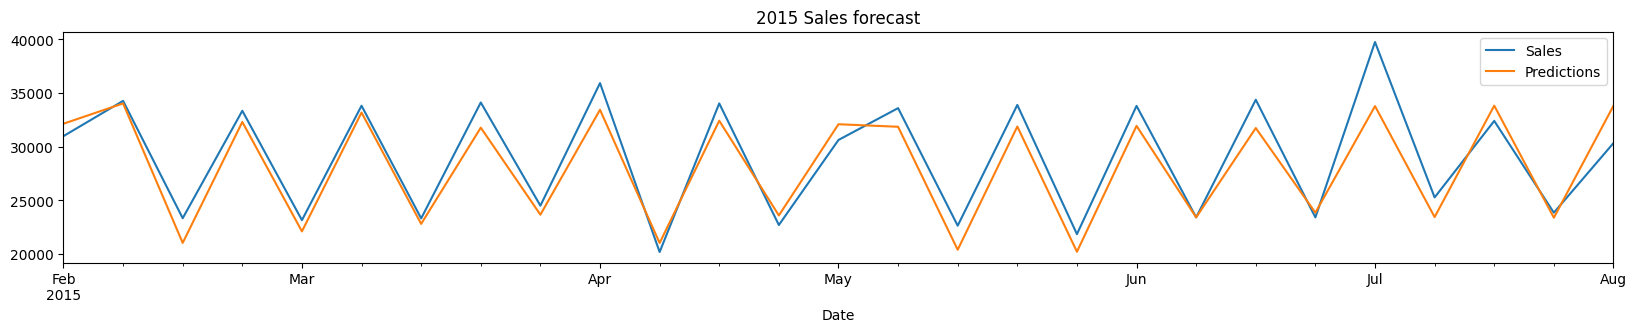

Validation MAE: 1599.5010010804651 -- Validation MSE: 3967025.5917728823


In [22]:
results_df = get_forecast(validation_weekly_features, history_df, xgbr_regressor)
results_df["Sales"] = validation_trues

mae = mean_absolute_error(results_df["Sales"], results_df["Predictions"])
mse = mean_squared_error(results_df["Sales"], results_df["Predictions"])

plt.figure()
plt.title(f"2015 Sales forecast");

ax = results_df["Sales"].plot(kind="line", figsize=(20, 3))
results_df["Predictions"].plot(kind="line", ax=ax)
ax.legend();
plt.show()

print(f"Validation MAE: {mae} -- Validation MSE: {mse}")

The results aren't bad. The forecasted values seem to follow the actual sales trends closely, and it seems that the seasonal bahavior was also incorporated to the model. However, there are points, specially around the peaks and valleys, where the model does not perfectly align with the actual sales, indicating potential areas for model improvements.

### Parameter Optimization

As we can see, our model is heavily overfitted. Let's try to avoid this problem by doing some parameter optimization with Optuna.

First, we define the objective function to be minimized

In [23]:
def objetive(trial):
    params = {
        'objective': 'reg:squarederror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
    }
    
    model = XGBRegressor(**params, random_state=42)
    scorer = make_scorer(mean_squared_error)
    scores = cross_val_score(model, train_features, train_sales, cv=4, scoring=scorer)
    return np.mean(scores)

Now we create an Optuna study and optimize.

In [24]:
study = optuna.create_study(direction="minimize")
study.optimize(objetive, n_trials=100)

[I 2023-12-10 00:35:04,708] A new study created in memory with name: no-name-09924d08-3f4f-40fb-a0df-34b875a46c8a
[I 2023-12-10 00:35:05,018] Trial 0 finished with value: 0.20755094183319273 and parameters: {'booster': 'gblinear', 'max_depth': 3, 'min_child_weight': 1.1445006358371945, 'subsample': 0.19556160065218253, 'colsample_bytree': 0.33585093449023695, 'learning_rate': 0.2798126335526603, 'n_estimators': 58}. Best is trial 0 with value: 0.20755094183319273.
[I 2023-12-10 00:35:16,315] Trial 1 finished with value: 0.104580052343826 and parameters: {'booster': 'dart', 'max_depth': 4, 'min_child_weight': 1.4001085412174004, 'subsample': 0.4475466658442382, 'colsample_bytree': 0.7447678221886099, 'learning_rate': 0.044535180571411134, 'n_estimators': 452}. Best is trial 1 with value: 0.104580052343826.
[I 2023-12-10 00:35:16,576] Trial 2 finished with value: 0.2087478044339549 and parameters: {'booster': 'gblinear', 'max_depth': 8, 'min_child_weight': 8.587102348657018, 'subsample':

In [25]:
best_trial = study.best_trial
print(f"Best trial - Mean RMSE: {best_trial.value:.4f}")
print("Best trial parameters:")
for key, value in best_trial.params.items():
    print(f"\t- {key}: {value}")

Best trial - Mean RMSE: 0.0867
Best trial parameters:
	- booster: dart
	- max_depth: 9
	- min_child_weight: 1.3870008226120554
	- subsample: 0.501087033503625
	- colsample_bytree: 0.9605477979699043
	- learning_rate: 0.09134302409339448
	- n_estimators: 304


Now we can train your final model using the best hyperparameters

In [26]:
final_xgbr_regressor = XGBRegressor(**best_trial.params, random_state=42)
final_xgbr_regressor.fit(train_features, train_sales)

XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9605477979699043, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.09134302409339448, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1.3870008226120554, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=304,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### Evaluating using the validation set

As before, let's assess the power of our model using the validation set.

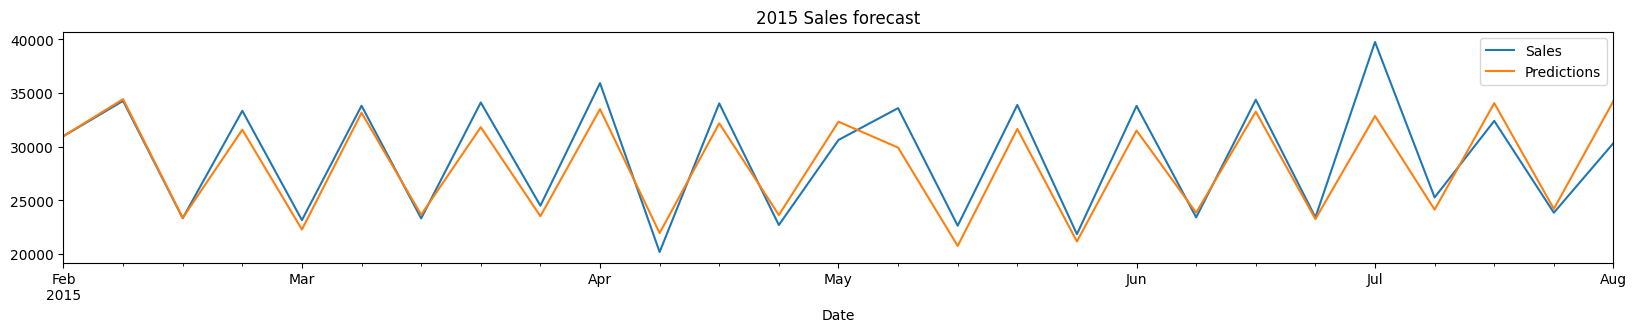

Validation MAE: 1566.0948655575864 -- Validation MSE: 4576660.655629875


In [27]:
history_df = weekly_features.copy()

results_df = get_forecast(validation_weekly_features, history_df, final_xgbr_regressor)
results_df["Sales"] = validation_trues

mae = mean_absolute_error(results_df["Sales"], results_df["Predictions"])
mse = mean_squared_error(results_df["Sales"], results_df["Predictions"])

plt.figure()
plt.title(f"2015 Sales forecast");

ax = results_df["Sales"].plot(kind="line", figsize=(20, 3))
results_df["Predictions"].plot(kind="line", ax=ax)
ax.legend();
plt.show()

print(f"Validation MAE: {mae} -- Validation MSE: {mse}")

Our final model didn't improved much with relation to our base model. In that sense, using one or another doesn't make much of a difference.